In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from tqdm import tqdm
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

In [3]:
from cwm.models.raft.raft_model import load_raft_model
from cwm.data.utils import FlowToRgb
from cwm.vis_utils import imshow

if not os.path.exists('../checkpoints/raft_checkpoints/'):
    os.chdir("../../CounterfactualWorldModels/cwm/models/raft")
    os.system("./download_raft_checkpoints.sh")
    os.chdir("../../../demo")

In [4]:
DEVICE = torch.device('cpu')
USE_GPU = True

if torch.cuda.is_available() and USE_GPU:
    DEVICE = torch.device('cuda:0')
elif torch.backends.mps.is_available() and USE_GPU:
    DEVICE = torch.device('mps')

In [5]:
## Load a RAFT model for predicting flow of counterfactual movies
raft = load_raft_model('../../CounterfactualWorldModels/checkpoints/raft_checkpoints/raft-large.pth').to(DEVICE)
raft = raft.eval().requires_grad_(False)

<All keys matched successfully> RAFT ../../CounterfactualWorldModels/checkpoints/raft_checkpoints/raft-large.pth


In [6]:
## Load a RAFT model for predicting keypoints of single images
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)

keypoint_url = os.path.join('https://counterfactual-world-modeling.s3.amazonaws.com',
                            'raft_consolidated_keypoint_predictor.pth')

!wget -nc --show-progress -P $model_checkpoint_dir $keypoint_url

File ‘../../CounterfactualWorldModels/checkpoints/raft_consolidated_keypoint_predictor.pth’ already there; not retrieving.



In [7]:
keypoint_predictor = load_raft_model(None, output_dim=1)
keypoint_predictor_load_path = os.path.join(model_checkpoint_dir,
                                            'raft_consolidated_keypoint_predictor.pth')
did_load = keypoint_predictor.load_state_dict(
    torch.load(keypoint_predictor_load_path, map_location='cpu')['model']
)
keypoint_predictor = keypoint_predictor.eval().requires_grad_(False).to(DEVICE)
print(did_load, keypoint_predictor_load_path)

created a new RAFT with 5552961 parameters
<All keys matched successfully> ../../CounterfactualWorldModels/checkpoints/raft_consolidated_keypoint_predictor.pth


In [8]:
def load_img(file_name, crop_size=None, size=[224, 224], device=DEVICE):
    img = Image.open(file_name)
    img = np.array(img)
    tr = transforms.Compose([
        transforms.ToTensor(),
        (transforms.CenterCrop(crop_size) if crop_size is not None else torch.nn.Identity()),
        transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),
    ])

    vid = torch.stack([tr(_img)[0:3] for _img in (img, img)], 0)[None].to(device)    
    return vid

### Load CWMs (head motion-conditioned and non-head-motion-conditioned)

In [9]:
## Download checkpoint for base 8x8 model
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    
## download base 8x8 2-frame model
base8x8_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_baseVMAE_224px_8x8patches_2frames.pth'
base4x4_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_largeVMAE_224px_4x4patches_2frames.pth'

!wget -nc --show-progress -P $model_checkpoint_dir $base8x8_url
!wget -nc --show-progress -P $model_checkpoint_dir $base4x4_url

File ‘../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth’ already there; not retrieving.

File ‘../../CounterfactualWorldModels/checkpoints/cwm_largeVMAE_224px_4x4patches_2frames.pth’ already there; not retrieving.



In [10]:
## Download weights for model that predicts IMU from two frames (and optical flow) and the IMU-conditioned predictor
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    
base_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/'
flow2imu_url = base_url + 'flow2imu_conjVMAE_224px.pth'
psiH_4x4base_url = base_url + 'cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth' 

!wget -nc --show-progress -P $model_checkpoint_dir $flow2imu_url
!wget -nc --show-progress -P $model_checkpoint_dir $psiH_4x4base_url

File ‘../../CounterfactualWorldModels/checkpoints/flow2imu_conjVMAE_224px.pth’ already there; not retrieving.

File ‘../../CounterfactualWorldModels/checkpoints/cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth’ already there; not retrieving.



In [11]:
## build and load a VMAE pretrained with the temporally-factored masking policy
import cwm.models.VideoMAE.vmae as vmae

USE_FLASH_ATTENTION = False

## to use base 8x8 model, uncomment this line
# model_func = vmae.base_8x8patch_2frames_1tube
# model_path = os.path.join(model_checkpoint_dir, base8x8_url.split('/')[-1])

## to use large 4x4 model, uncomment this line
model_func = vmae.large_4x4patch_2frames_1tube
model_path = os.path.join(model_checkpoint_dir, base4x4_url.split('/')[-1])

model = model_func(use_flash_attention=(USE_FLASH_ATTENTION and ('cuda' in DEVICE.type)))
model.eval().requires_grad_(False).to(DEVICE)
print("Num parameters: %d" % sum([v.numel() for v in model.parameters()]))

did_load = model.load_state_dict(torch.load(model_path, map_location='cpu')['model'])
print(did_load, model_func.__name__, model_path, "device: %s" % DEVICE)

NUM PATCHES IN ENCODER 6272
Num parameters: 340709936
<All keys matched successfully> large_4x4patch_2frames_1tube ../../CounterfactualWorldModels/checkpoints/cwm_largeVMAE_224px_4x4patches_2frames.pth device: mps


In [13]:
'''
Create a way of generating mask inputs to the model, and wrap it for easy prediction
We call the model wrapper Psi, whose main method is making a prediction, y, via
 
      y = Psi.predict(x, mask)
      
where
     - x is a video of shape (B,2,3,*model.img_size)
     - mask is a boolean mask of shape (B, num_patches), with num_patches = np.prod(model.mask_size)
     
'''

import cwm.models.masking as masking
import cwm.models.segmentation as segmentation

MASK_RATIO = 0.99
CLUMPING_FACTOR = 2

# an object that generates temporally-factored masks. mask_ratio of the second frame is masked out.
# clumping_factor determines how much visible patches will be clumped (default 1)
mask_generator = masking.RotatedTableUniformMaskingGenerator(
    input_size=model.mask_size,
    mask_ratio=MASK_RATIO,
    clumping_factor=CLUMPING_FACTOR,
    randomize_num_visible=False,
    always_batch=True,
    seed=0
).requires_grad_(False).to(DEVICE)

# the wrapper for making predictions
Psi = segmentation.FlowGenerator(
        predictor=model, # the model function with loaded weights
        temporal_dim=2, # the base models take inputs of shape [B,3,T,H,W]; the wrapper Psi handles reshaping
        imagenet_normalize_inputs=True, # because these models were trained with normalization
        mask_generator=mask_generator, # a way of generating masks automatically if desired
        seed=0,
        flow_model=raft, # set RAFT to easily evaluate flow
        keypoint_predictor=keypoint_predictor,
        patch_sampling_kwargs={'clumping_factor': 2}
).requires_grad_(False).to(DEVICE)

# 
mask = mask_generator()
print("\n")
print("example mask shape: %s" % list(mask.shape))
print("number of visible patches: %d" % mask.sum().item())

No predictor weights were loaded in constructing the FlowGenerator
This is fine as long as you already loaded the weights!
No predictor weights were loaded in constructing the FlowGenerator
This is fine as long as you already loaded the weights!
set RAFT to 24 iters
set RAFT to 24 iters


example mask shape: [1, 6272]
number of visible patches: 3104


In [14]:
import cwm.models.VideoMAE.conjoined_vmae as conj

MASK_RATIO = 0.99
CLUMPING_FACTOR = 2

flow2imu_ckpt = os.path.join(model_checkpoint_dir, 'flow2imu_conjVMAE_224px.pth')
flow2imu_model = conj.imu400_8x8patch_2frames_1tube_flowbackrgb01()
did_load = flow2imu_model.load_state_dict(
    torch.load(flow2imu_ckpt, map_location='cpu')['model'],
    strict=False)
print(did_load, flow2imu_ckpt)

imu_conditioned_ckpt = os.path.join(model_checkpoint_dir, 'cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth')
imu_conditioned_model = conj.imu400_base_4x4patch_2frames_1tube()
did_load = imu_conditioned_model.load_state_dict(
    torch.load(imu_conditioned_ckpt, map_location='cpu')['model'],
    strict=False)
print(did_load, imu_conditioned_ckpt)

mask_generator_4x4 = masking.RotatedTableUniformMaskingGenerator(
    input_size=imu_conditioned_model.mask_size,
    mask_ratio=MASK_RATIO,
    clumping_factor=CLUMPING_FACTOR
).to(DEVICE)

PsiH = segmentation.ImuConditionedFlowGenerator(
        predictor=imu_conditioned_model, # the model function with loaded weights
        head_motion_predictor=flow2imu_model, # the model that infers missing IMU data from a movie
        temporal_dim=2, # the base models take inputs of shape [B,3,T,H,W]; the wrapper Psi handles reshaping
        imagenet_normalize_inputs=True, # because these models were trained with normalization
        mask_generator=mask_generator_4x4, # a way of generating masks automatically if desired
        seed=0,
        flow_model=raft, # set RAFT to easily evaluate flow
        raft_iters=24,
        keypoint_predictor=keypoint_predictor,
        patch_sampling_kwargs={'clumping_factor': 2}
).requires_grad_(False).to(DEVICE)

<All keys matched successfully> RAFT ../checkpoints/raft_checkpoints/raft-large.pth
NUM PATCHES IN ENCODER 784
NUM PATCHES IN ENCODER 25
1 main frames: [0, 1]
0 context frames: None
2 total frames
Parameter Breakdown:
Main stream: 92956480
Context stream: 23272512
Conjoining: 19501056
Total: 135730048
<All keys matched successfully> ../../CounterfactualWorldModels/checkpoints/flow2imu_conjVMAE_224px.pth
NUM PATCHES IN ENCODER 6272
NUM PATCHES IN ENCODER 25
2 main frames: [0, 1]
0 context frames: None
2 total frames
Parameter Breakdown:
Main stream: 92496432
Context stream: 23272992
Conjoining: 32495616
Total: 148265040
<All keys matched successfully> ../../CounterfactualWorldModels/checkpoints/cwm_IMUcond_conjVMAE_224px_4x4patches_2frames.pth
No predictor weights were loaded in constructing the ImuConditionedFlowGenerator
This is fine as long as you already loaded the weights!
No predictor weights were loaded in constructing the ImuConditionedFlowGenerator
This is fine as long as you a

## Algorithms for finding which parts of a scene are most movable

In [15]:
# set this to some place you have e.g. images from your smartphone
# demo_images_dir = './images/'
demo_images_dir = '../../datasets/home_images/'
img_files = !ls $demo_images_dir
img_files = sorted(img_files)
for i,name in enumerate(img_files):
    print(i, name)

0 ABB_belt.jpeg
1 berkshiregrey.jpeg
2 blocks.png
3 boxes_belt.jpeg
4 eggs.png
5 nomagic.jpeg
6 universal.png


/Users/db/neuroailab/.neuroailab/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x2d2a02e20>, <Axes: >)

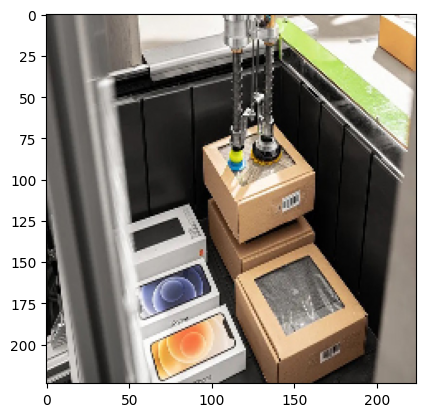

In [16]:
%matplotlib inline
img_idx = 5
img_file_name = img_files[img_idx]
x = load_img(
    os.path.join(
        demo_images_dir, 
        img_file_name),
    crop_size=None, device=DEVICE)
imshow(x, t=0)

filtering by ['patch_magnitude', 'flow_area', 'num_corners']
using flow_magnitude_threshold 5.0
using flow_area_threshold 0.75
using num_corners_threshold 2

Create motion counterfactuals.

> click: place an active patch that will move by some integer number of patch widths
> right (or Command)-click: place a passive patch that will remain fixed in place
> CTRL or F-click: run the motion counterfactual with selected patches. Motion vector will be chosen randomly
> B-click: run S=sample_batch_size motion counterfactuals with random or preset_shifts directions
> X-click: compute the covariance matrix of collected flow samples and display its row (image) at the clicked point
> hold-D and drag: set the direction of the motion counterfactual; active patches will change color to indicate this
> SHIFT-click: reset the chosen patches



<IPython.core.display.Javascript object>


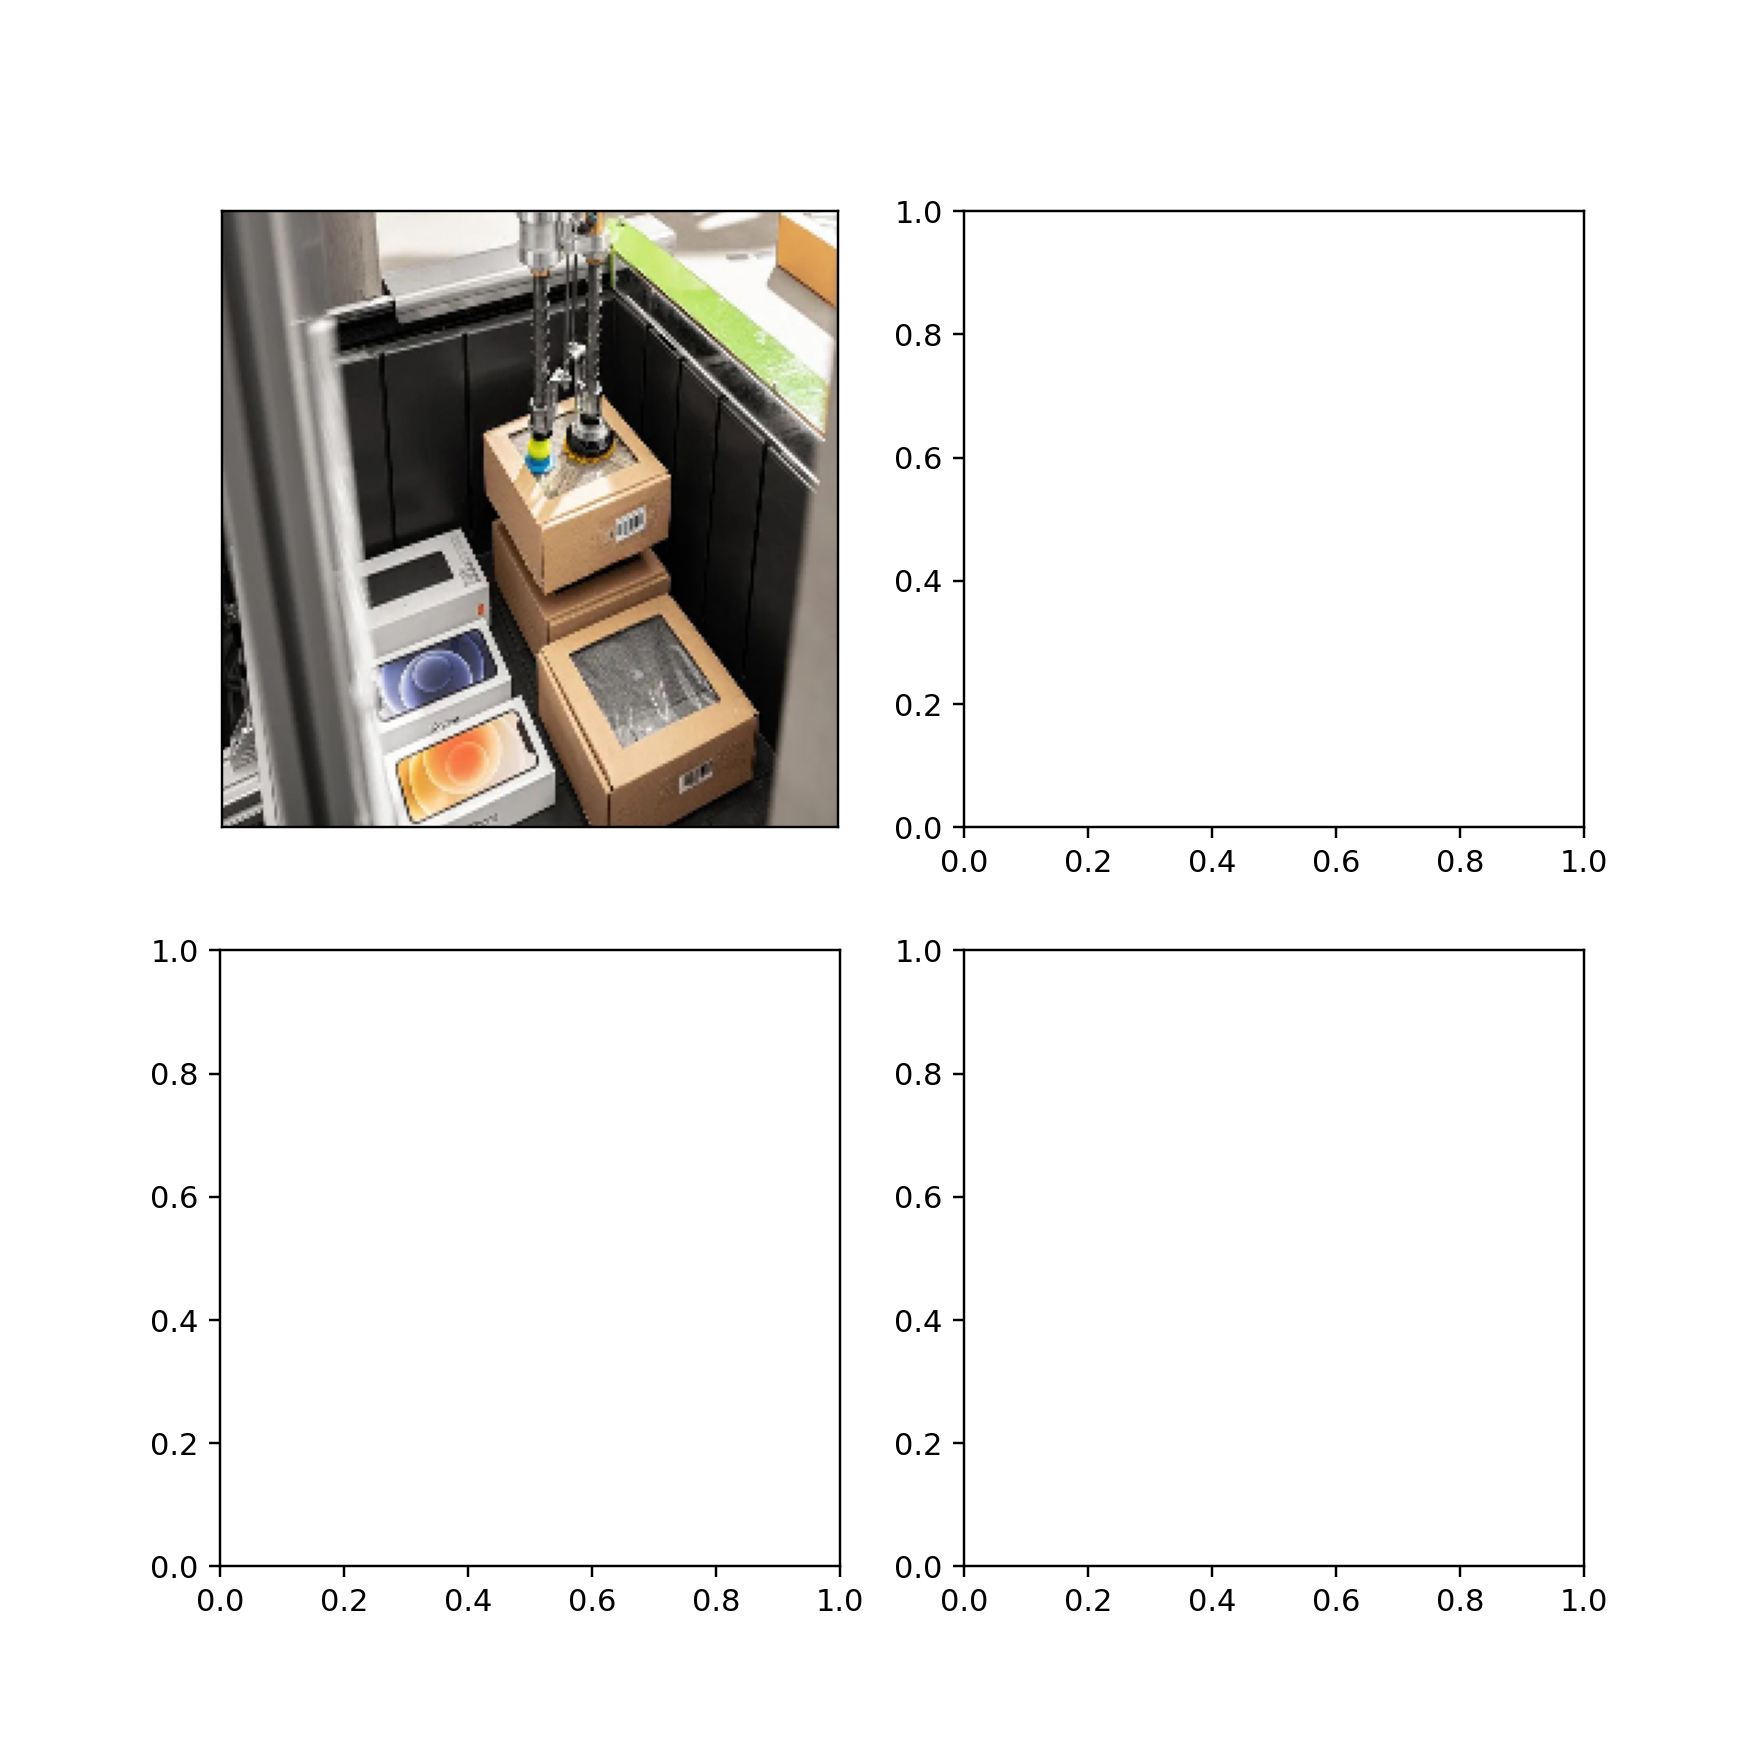

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [17]:
%matplotlib notebook
import cwm.interface as interface

## choose which predictor to use
PsiInterface = PsiH # head motion conditioned
# PsiInterface = Psi # non-head motion conditioned

## can filter flow samples based on certain criteria
## if filter_params is None, no filtering will occur
filter_params = {
    'filter_methods': ['patch_magnitude', 'flow_area', 'num_corners'],
    'flow_magnitude_threshold': 5.0,
    'flow_area_threshold': 0.75,
    'num_corners_threshold': 2
}
# filter_params = None

PsiInterface.set_flow_sample_filter(filter_params)
print(PsiInterface.flow_sample_filter)

docstr = '''
Create motion counterfactuals.

> click: place an active patch that will move by some integer number of patch widths
> right (or Command)-click: place a passive patch that will remain fixed in place
> CTRL or F-click: run the motion counterfactual with selected patches. Motion vector will be chosen randomly
> B-click: run S=sample_batch_size motion counterfactuals with random or preset_shifts directions
> X-click: compute the covariance matrix of collected flow samples and display its row (image) at the clicked point
> hold-D and drag: set the direction of the motion counterfactual; active patches will change color to indicate this
> SHIFT-click: reset the chosen patches
'''

print(docstr)

preset_shifts = [[2, 0], [0, 2], [-2, 0], [0, -2], [2, 2], [-2, -2], [2, -2], [-2, 2]]
# preset_shifts = None

fig, axes = plt.subplots(2, 2, figsize=(8,8))
I = interface.CounterfactualPredictionInterface(
    axes=axes,
    G=PsiInterface, # masked predictor wrapper with a method for predictinf flow
    x=x, # your image
    device=x.device, # where to run it
    active_color=[0, 1, 0], # what color to show active patches as when motion counterfactual direction is unset
    passive_color=[1, 0, 0], # what color to show passive (static) patches as
    preset_shifts=preset_shifts, # to run a particular set of directional motion counterfactuals, pass as a list
    max_shift=3, # maximum number of patch widths to make motion counterfactuals with
    show_ticks=False,
    sample_batch_size=8, # how many motion counterfactual samples to run when pressing 'B'
    max_samples_per_batch=4, # batch size for motion motion counterfactuals
    static_head_motion=True, # whether head motion will be assumed to be zero
    covmat_downsample=2, # how much to downsample flow samples when computing covariance matrix
    click_patch_width=1 # select clumps of patches at once with width C
)

In [18]:
%matplotlib inline

PsiInterface.set_input(x)
masks = PsiInterface.sample_patches_from_energy()
masks.shape


torch.Size([1, 6272, 10])

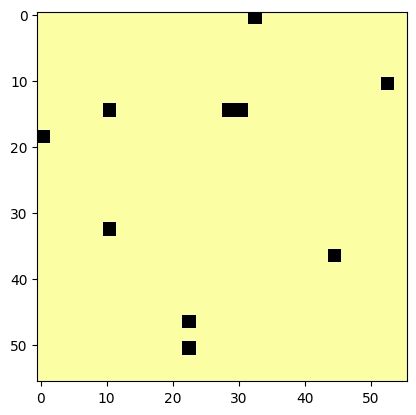

In [20]:
PsiInterface.maskshow(masks.amin(-1), t=1)

/Users/db/neuroailab/.neuroailab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/db/neuroailab/.neuroailab/lib/python3.8/site-packages/torch/nn/functional.py:4244: UserWarning: MPS: grid_sampler_2d op is supported natively starting from macOS 13.1. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/GridSampler.mm:139.)
  return torch.grid_sampler(input, grid, mode_enum, padding_mode_enum, align_corners)
/Users/db/neuroailab/.neuroailab/lib/python3.8/site-packages/torch/nn/functional.py:4697: UserWarning: The operator 'aten::im2col' is not currently supported on the MPS backend and

(<matplotlib.image.AxesImage at 0x2ddd460a0>, <Axes: >)

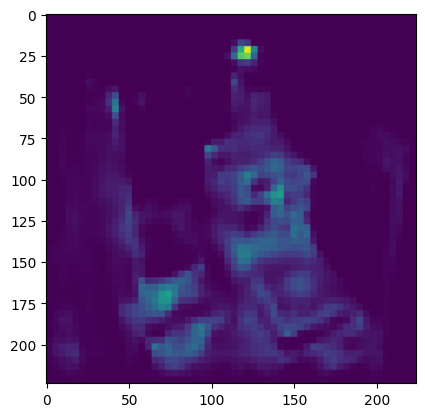

In [21]:
kps = Psi.predict_keypoints_distribution(x, power=8)
imshow(kps)

In [22]:

PsiInterface.set_input(x)
masks = PsiInterface.sample_patches_from_energy(kps)
masks.shape

torch.Size([1, 6272, 10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


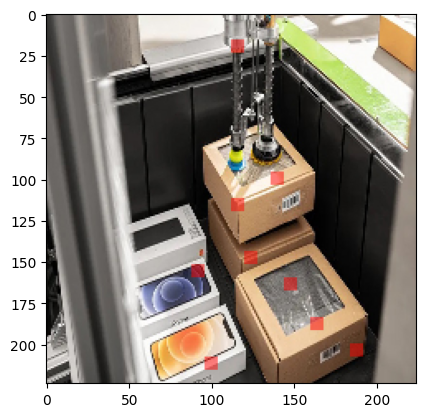

In [23]:
alpha = PsiInterface.get_masked_pred_patches(
    torch.zeros_like(PsiInterface.x), masks.amin(-1), fill_value=[1,0,0])[:,:,0:1]
img = PsiInterface.x.clone()
red = torch.cat([alpha, torch.zeros_like(alpha), torch.zeros_like(alpha)], -3)
img = img * (1 - alpha) + 0.5 * alpha * (red + img)
imshow(img, t=1)
plt.show()

In [60]:
%matplotlib inline
fs, actives, passives = PsiInterface.sample_counterfactual_motion_map(
    x,
    active_sampling_distribution=kps,
    passive_sampling_distribution=None,
    num_active_patches=1,
    num_passive_patches=1,
    num_samples=32,
    sample_batch_size=4,
    do_filter=False,
    patch_sampling_kwargs={'clumping_factor': 2}
)

In [61]:
fs_mag = PsiInterface.compute_flow_samples_magnitude(fs, normalize=False)
fs_mag = fs_mag.mean(-1)
fs_mag = fs_mag - fs_mag.amin((-2, -1), True)
fs_mag = fs_mag / fs_mag.amax((-2, -1), True).clamp(min=1e-3)
print(fs_mag.shape)

torch.Size([1, 1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x301e827c0>, <Axes: >)

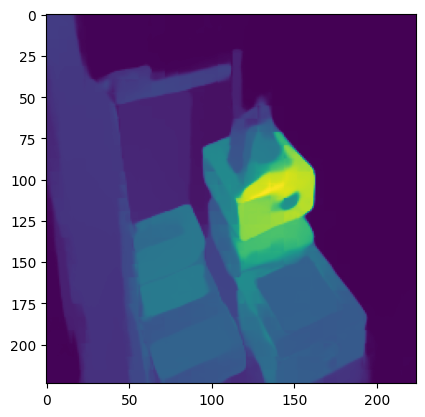

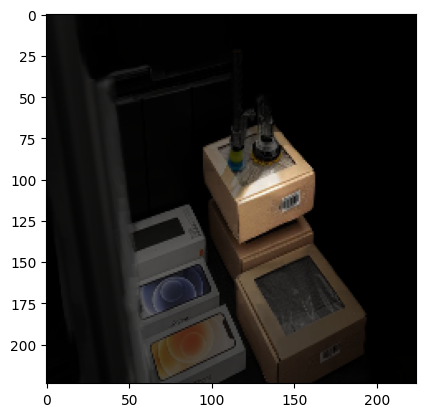

In [62]:
imshow(fs_mag)
imshow(x[:,0] * fs_mag)

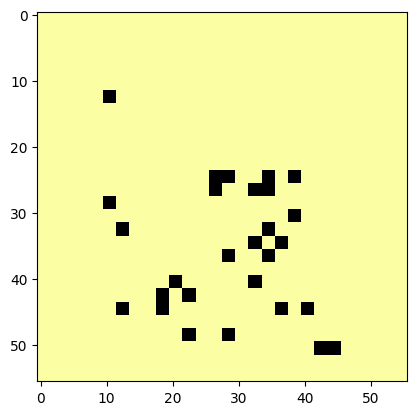

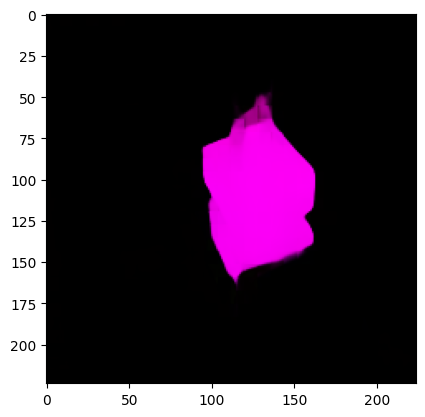

In [63]:
PsiInterface.maskshow(actives.amin(-1), t=1)
PsiInterface.flowshow(fs[...,2])